# Model

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType

In [2]:
spark = SparkSession.builder.master('local[*]').appName('classification').getOrCreate()

### Loading the data

In [3]:
# cases
case_data = "sa311/case.csv"
df_case = spark.read.csv(case_data, header=True)

dept_data = "sa311/dept.csv"
df_dept = spark.read.csv(dept_data, header=True)

In [4]:
df = df_case.join(df_dept, 'dept_division', 'left_outer')

In [5]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: string (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)



### Normalizing the text data

In [6]:
df = df.select(F.lower(col('dept_division')).alias('dept_division'), 
          F.lower(col('service_request_type')).alias('request_type'),
          F.lower(col('dept_name')).alias('dept_name'),
          F.lower(col('standardized_dept_name')).alias('dept_name_std'),
          (col('case_closed')=='YES').alias('case_closed'),
          F.when(col('case_late')=='YES', 1).otherwise(0).alias('target'),
          (col('dept_subject_to_SLA')=='YES').alias('dept_w_SLA'),
          F.round(col('num_days_late').cast(DoubleType()), 2).alias('days_late'),
          F.round(col('SLA_days').cast(DoubleType()), 2).alias('SLA_days'),
          F.regexp_extract(col('request_address'),"(\d{5})$", 1).\
               alias("request_address_zip")
         )

### Don't want to use both dept_name and dept_name_std 
So let's look at unique values to see which is more cleaned up.

In [7]:
df.select(F.countDistinct('dept_division'), 
          F.countDistinct('dept_name'),
          F.countDistinct('dept_name_std'),
          F.countDistinct('request_type')).\
          toPandas().transpose()

,0
count(DISTINCT dept_division),39
count(DISTINCT dept_name),9
count(DISTINCT dept_name_std),8
count(DISTINCT request_type),334


### Using the standardized department name, given it has fewer distinct values

In [8]:
df = df.drop('dept_name')

### Preprocess the modeling data.
### Using the SQLTransformer to filter out rows that don't apply
`__THIS__` is a placeholder for the DataFrame passed into the transform method.

In [9]:
from pyspark.ml.feature import SQLTransformer

filterer = SQLTransformer(
    statement="SELECT * FROM __THIS__ WHERE dept_w_SLA AND case_closed")

filtered = filterer.transform(df)

### Generate label
### We can treat `target_var` as a continuous numerical label or an ordered categorical label

In [10]:
filtered.\
    groupBy('target').\
    count().orderBy('target').show()

+------+------+
|target| count|
+------+------+
|     0|735612|
|     1| 87978|
+------+------+



In [11]:
filtered.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name_std: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)



### Extract, transform, and select features
### Create function to explore features

In [12]:
def explore(df, target, cont1, cont2):
    from pyspark.sql.functions import count, mean, corr
    aggregated = (df.groupby(target).agg(count(cont1),
                                        mean(cont1),
                                        mean(cont2),
                                        corr(cont1,cont2))
                  .orderBy(target))
    aggregated.show()

In [13]:
explore(filtered, 'target','SLA_days','days_late')

+------+---------------+------------------+------------------+-------------------------+
|target|count(SLA_days)|     avg(SLA_days)|    avg(days_late)|corr(SLA_days, days_late)|
+------+---------------+------------------+------------------+-------------------------+
|     0|         735612| 64.44108282627009|-58.57142732854887|       -0.997626452823121|
|     1|          87978|14.202606674396014|22.111734751869776|      0.24758733973851155|
+------+---------------+------------------+------------------+-------------------------+



The cases that are past their due date seem to have shorter SLA's

In [14]:
sample_pdf = (filtered.select('SLA_days', 'days_late', 'target')
              .sample(False, 0.20, 12345)
              .toPandas())

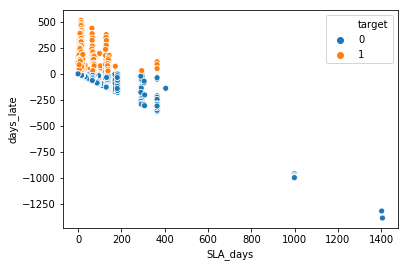

In [15]:
sns.scatterplot(x=sample_pdf.SLA_days, 
                y=sample_pdf.days_late,
                hue=sample_pdf.target
               )

plt.show()

### Indexing/Encoding dept_name_std

In [16]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="dept_name_std", outputCol="dept_name_std_ix")
indexer_model = indexer.fit(filtered)
list(enumerate(indexer_model.labels))
indexed = indexer_model.transform(filtered)
indexed.select("dept_name_std", "dept_name_std_ix").show(5)

+--------------------+----------------+
|       dept_name_std|dept_name_std_ix|
+--------------------+----------------+
|animal care services|             2.0|
|trans & cap impro...|             3.0|
|trans & cap impro...|             3.0|
|dsd/code enforcement|             0.0|
|animal care services|             2.0|
+--------------------+----------------+
only showing top 5 rows



### Creating dummy variables through OneHotEncoderEstimator
`cat_var1_cd` is stored as a SparseVector.

In [23]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["dept_name_std_ix"], outputCols=["dept_name_std_cd"])
encoded_model = encoder.fit(indexed)
encoded = encoded_model.transform(indexed)
encoded.select("dept_name_std", "dept_name_std_ix", "dept_name_std_cd").show(5)

+--------------------+----------------+----------------+
|       dept_name_std|dept_name_std_ix|dept_name_std_cd|
+--------------------+----------------+----------------+
|animal care services|             2.0|   (6,[2],[1.0])|
|trans & cap impro...|             3.0|   (6,[3],[1.0])|
|trans & cap impro...|             3.0|   (6,[3],[1.0])|
|dsd/code enforcement|             0.0|   (6,[0],[1.0])|
|animal care services|             2.0|   (6,[2],[1.0])|
+--------------------+----------------+----------------+
only showing top 5 rows



### Now we can (manually) select our features and label

In [30]:
selected = encoded.select("SLA_days", "dept_name_std_cd", "target")
features = ["SLA_days", "dept_name_std_cd"]

### The machine learning algorithms in Spark MLlib expect the features to be collected into a single column, so we use VectorAssembler to assemble our feature vector
`features` is stored as a SparseVector

In [31]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(selected)
assembled.head(5)

[Row(SLA_days=999.0, dept_name_std_cd=SparseVector(6, {2: 1.0}), target=0, features=SparseVector(7, {0: 999.0, 3: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), target=0, features=SparseVector(7, {0: 4.32, 4: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), target=0, features=SparseVector(7, {0: 4.32, 4: 1.0})),
 Row(SLA_days=16.29, dept_name_std_cd=SparseVector(6, {0: 1.0}), target=0, features=SparseVector(7, {0: 16.29, 1: 1.0})),
 Row(SLA_days=0.13, dept_name_std_cd=SparseVector(6, {2: 1.0}), target=1, features=SparseVector(7, {0: 0.13, 3: 1.0}))]

### Save data for subsequent models

In [32]:
assembled.write.parquet("sa311/assembled", mode="overwrite")

### Creating train and test sets
### Model will be fit to the train DataFrame then be evaluated on the test DataFrame
Weights must be Doubles type.

In [35]:
train, test = assembled.randomSplit([0.7, 0.3], 12345)

### Specify a logistic regression model
### Use the LogisticRegression class to specify a logistic regression model
featureCol is only one column, hence why we put the features into one vector. Same with target.

In [37]:
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol="features", labelCol="target")

### Use the `explainParams` method to get a full list of hyperparameters

In [38]:
print(log_reg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: target)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. Th

### Fit the logistic regression model
### Use the fit method to fit the logistic regression model on the train DataFrame

In [39]:
log_reg_model = log_reg.fit(train)

### The result is an instance of the LogisticRegressionModel class

In [43]:
type(log_reg_model)

pyspark.ml.classification.LogisticRegressionModel

### The model parameters are stored in the intercept and coefficients attributes

In [44]:
log_reg_model.intercept

0.3287143767950738

In [49]:
log_reg_model.coefficients

DenseVector([-0.0148, -2.195, -2.2715, -1.3328, -2.8929, -1.6286, -1.8126])

### The summary attribute is an instance of the `BinaryLogisticRegressionTrainingSummary` class

In [51]:
type(log_reg_model.summary)

pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

### We can query the iteration history:

In [52]:
log_reg_model.summary.totalIterations

28

In [53]:
log_reg_model.summary.objectiveHistory

[0.3398522374414734,
 0.3340295527680015,
 0.3227611580762015,
 0.3209154175447656,
 0.3202449230605207,
 0.31981334158897606,
 0.3189923289886126,
 0.3186976460855554,
 0.3178598692587781,
 0.3173426275244338,
 0.31707996920672843,
 0.3170452016045578,
 0.3169590164695488,
 0.31694493835389326,
 0.3169270284273817,
 0.31683676838640057,
 0.31668267164653585,
 0.3163921118006834,
 0.3161736615320396,
 0.31612058604847154,
 0.3160523873449194,
 0.31604932297074223,
 0.3160492512856409,
 0.3160492494496807,
 0.31604924934195466,
 0.31604924932930817,
 0.31604924932472284,
 0.3160492493225822]

### And plot it too

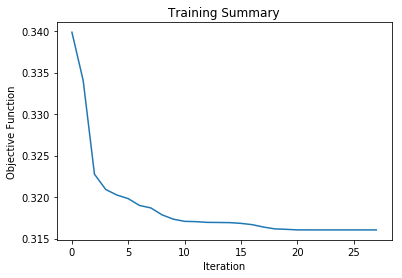

In [54]:
def plot_iterations(summary):
    plt.plot(summary.objectiveHistory)
    plt.title("Training Summary")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function")
    plt.show()
    
plot_iterations(log_reg_model.summary)

### The AUC-ROC Curve
AUC: Area Under The Curve

ROC: Receiver Operating Characteristics

TPR: True Positive Rate

FPR: False Positive Rate

### Query the area under the ROC curve to measure the model's performance

In [55]:
log_reg_model.summary.areaUnderROC

0.6693248796679715

### And plot the ROC curve

In [56]:
log_reg_model.summary.roc.show(5)

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|6.567149099542826E-4|0.00964833915373995|
| 0.09276583838984384|0.27416551612117274|
| 0.09325740310054927|0.27559489969950457|
| 0.09465826537888371| 0.2790384146836677|
+--------------------+-------------------+
only showing top 5 rows



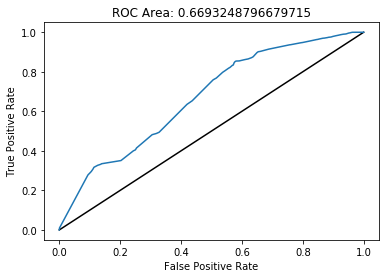

In [57]:
def plot_roc_curve(summary):
    roc_curve = summary.roc.toPandas()
    plt.plot(roc_curve["FPR"], roc_curve["FPR"], "k")
    plt.plot(roc_curve["FPR"], roc_curve["TPR"])
    plt.title("ROC Area: %s" % summary.areaUnderROC)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
plot_roc_curve(log_reg_model.summary)

### Evaluate model performance on the test set.
### We have been assessing the model performance on the train DataFrame. We really want to assess it on the test DataFrame.

### Method 1: Use the evaluate method of the LogisticRegressionModel class

In [58]:
test_summary = log_reg_model.evaluate(test)

### The result is an instance of the BinaryLogisticRegressionSummary class

In [59]:
type(test_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

### It has attributes similar to those of the BinaryLogisticRegressionTrainingSummary class

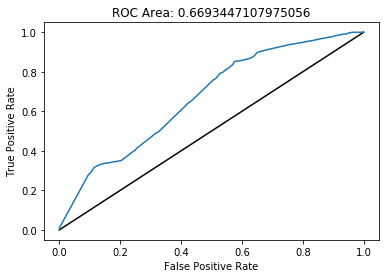

In [60]:
test_summary.areaUnderROC
plot_roc_curve(test_summary)

### Method 2: Use the evaluate method of the BinaryClassificationEvaluator class.

### Generate predictions on the test DataFrame:

In [61]:
test_with_prediction = log_reg_model.transform(test)
test_with_prediction.show(5)

+--------+----------------+------+--------------------+--------------------+--------------------+----------+
|SLA_days|dept_name_std_cd|target|            features|       rawPrediction|         probability|prediction|
+--------+----------------+------+--------------------+--------------------+--------------------+----------+
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048566...|[0.73224030160843...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048566...|[0.73224030160843...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048566...|[0.73224030160843...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048566...|[0.73224030160843...|       0.0|
|    0.13|   (6,[2],[1.0])|     0|(7,[0,3],[0.13,1.0])|[1.00601881048566...|[0.73224030160843...|       0.0|
+--------+----------------+------+--------------------+--------------------+--------------------+----------+
only showing top 5 

### The resulting DataFrame includes three types of predictions. 
The `rawPrediction` is a vector of log-odds, `probability` is a vector of probabilities, and `prediction` is the predicted class based on the probability vector.

# Exercises

1. Determine if request_address_zip is a promising feature.

1. Reassemble the feature vector and include request_address_zip.

1. Create new train and test datasets.

1. Refit the logistic regression model on the train dataset.

1. Apply the refit logistic model to the test dataset.

1. Compute the AUC on the test dataset.

##### Determine if request_address_zip is a promising feature.
It looks like it can be.

In [76]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name_std: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)



In [80]:
(df.select('request_address_zip', 'target')
 .groupBy('request_address_zip')
 .agg(F.mean('target'), F.count('request_address_zip'))
 .orderBy('avg(target)', ascending=False)
 .show())

+-------------------+-------------------+--------------------------+
|request_address_zip|        avg(target)|count(request_address_zip)|
+-------------------+-------------------+--------------------------+
|              78112|0.35526315789473684|                       152|
|              78073| 0.2881944444444444|                       288|
|              78109| 0.2673758865248227|                      1410|
|              78243|               0.25|                         4|
|              78264|0.22344322344322345|                       273|
|              78261|0.21212121212121213|                        33|
|              78239|0.20076849183477424|                      2082|
|              78244|0.18505338078291814|                      5339|
|              78253| 0.1840607210626186|                       527|
|              78101|0.18181818181818182|                        11|
|              78257|0.17199558985667035|                       907|
|              78023|0.17099697885

In [106]:
pdf = (df.select(col('request_address_zip').alias('zip'), 'target')
 .groupBy('zip')
 .agg(F.mean('target').alias('average'), F.count('zip').alias('count'))
 .toPandas())

In [107]:
pdf.head()

,zip,average,count
0,78073,0.288194,288
1,78211,0.130609,20481
2,78228,0.127741,37709
3,78254,0.152676,6576
4,78223,0.131154,26099


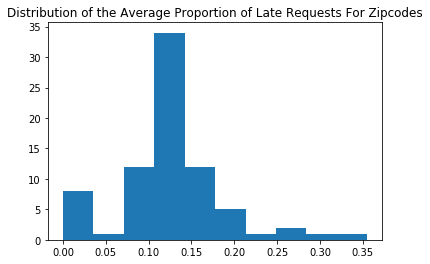

In [125]:
plt.hist(pdf.average)
plt.title('Distribution of the Average Proportion of Late Requests For Zipcodes')
plt.show()

##### Reassemble the feature vector and include request_address_zip.

Replacing empty strings in zip with 'no_zipcode'.

In [ ]:
filtered = (filtered.withColumn('request_address_zip', 
                     F.when(col('request_address_zip') == '', 'no_zipcode')
                     .otherwise(col('request_address_zip'))))

In [150]:
filtered.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name_std: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)



Indexing all the different strings in the zip column.

In [151]:
indexer = StringIndexer(inputCol='request_address_zip',
                        outputCol='request_address_zip_idx')
indexer_model = indexer.fit(filtered)
indexed = indexer_model.transform(filtered)
indexed.select('request_address_zip', 'request_address_zip_idx').show()

+-------------------+-----------------------+
|request_address_zip|request_address_zip_idx|
+-------------------+-----------------------+
|              78207|                    1.0|
|              78223|                    8.0|
|              78223|                    8.0|
|              78223|                    8.0|
|              78228|                    2.0|
|         no_zipcode|                    0.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|             

Same for the dept_name column.

In [153]:
indexer = StringIndexer(inputCol='dept_name_std',
                        outputCol='dept_name_std_idx')
indexer_model = indexer.fit(indexed)
indexed = indexer_model.transform(indexed)
indexed.select('dept_name_std', 'dept_name_std_idx').show()

+-------------------+-----------------------+
|request_address_zip|request_address_zip_idx|
+-------------------+-----------------------+
|              78207|                    1.0|
|              78223|                    8.0|
|              78223|                    8.0|
|              78223|                    8.0|
|              78228|                    2.0|
|         no_zipcode|                    0.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|                    4.0|
|              78251|             

In [155]:
indexed.show(5)

+----------------+--------------------+--------------------+-----------+------+----------+---------+--------+-------------------+-----------------------+-----------------+
|   dept_division|        request_type|       dept_name_std|case_closed|target|dept_w_SLA|days_late|SLA_days|request_address_zip|request_address_zip_idx|dept_name_std_idx|
+----------------+--------------------+--------------------+-----------+------+----------+---------+--------+-------------------+-----------------------+-----------------+
|field operations|        stray animal|animal care services|       true|     0|      true|  -998.51|   999.0|              78207|                    1.0|              2.0|
|     storm water|removal of obstru...|trans & cap impro...|       true|     0|      true|    -2.01|    4.32|              78223|                    8.0|              3.0|
|     storm water|removal of obstru...|trans & cap impro...|       true|     0|      true|    -3.02|    4.32|              78223|           

Creating dummy variables for zip_idx and dept_name_idx

In [157]:
encoder = (OneHotEncoderEstimator(inputCols=['request_address_zip_idx', 'dept_name_std_idx'],
                        outputCols=['request_address_zip_cd', 'dept_name_std_cd']))
encoder_model = encoder.fit(indexed)
encoded = encoder_model.transform(indexed)
(encoded.select('request_address_zip_idx', 
                'dept_name_std_idx', 
                'request_address_zip_cd', 
                'dept_name_std_cd').show())

+-----------------------+-----------------+----------------------+----------------+
|request_address_zip_idx|dept_name_std_idx|request_address_zip_cd|dept_name_std_cd|
+-----------------------+-----------------+----------------------+----------------+
|                    1.0|              2.0|        (75,[1],[1.0])|   (6,[2],[1.0])|
|                    8.0|              3.0|        (75,[8],[1.0])|   (6,[3],[1.0])|
|                    8.0|              3.0|        (75,[8],[1.0])|   (6,[3],[1.0])|
|                    8.0|              0.0|        (75,[8],[1.0])|   (6,[0],[1.0])|
|                    2.0|              2.0|        (75,[2],[1.0])|   (6,[2],[1.0])|
|                    0.0|              3.0|        (75,[0],[1.0])|   (6,[3],[1.0])|
|                    4.0|              0.0|        (75,[4],[1.0])|   (6,[0],[1.0])|
|                    4.0|              0.0|        (75,[4],[1.0])|   (6,[0],[1.0])|
|                    4.0|              0.0|        (75,[4],[1.0])|   (6,[0],

Selecting the x and y variables.

In [158]:
selected = encoded.select("SLA_days", "dept_name_std_cd", 'request_address_zip_cd', "target")
features = ["SLA_days", "dept_name_std_cd", 'request_address_zip_cd']

Putting all the features together in a vector so that SparkML will be able to use it.

In [160]:
assembler = VectorAssembler(inputCols=features, outputCol='features')
assembled = assembler.transform(selected)

In [161]:
assembled.head(5)

[Row(SLA_days=999.0, dept_name_std_cd=SparseVector(6, {2: 1.0}), request_address_zip_cd=SparseVector(75, {1: 1.0}), target=0, features=SparseVector(82, {0: 999.0, 3: 1.0, 8: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), request_address_zip_cd=SparseVector(75, {8: 1.0}), target=0, features=SparseVector(82, {0: 4.32, 4: 1.0, 15: 1.0})),
 Row(SLA_days=4.32, dept_name_std_cd=SparseVector(6, {3: 1.0}), request_address_zip_cd=SparseVector(75, {8: 1.0}), target=0, features=SparseVector(82, {0: 4.32, 4: 1.0, 15: 1.0})),
 Row(SLA_days=16.29, dept_name_std_cd=SparseVector(6, {0: 1.0}), request_address_zip_cd=SparseVector(75, {8: 1.0}), target=0, features=SparseVector(82, {0: 16.29, 1: 1.0, 15: 1.0})),
 Row(SLA_days=0.13, dept_name_std_cd=SparseVector(6, {2: 1.0}), request_address_zip_cd=SparseVector(75, {2: 1.0}), target=1, features=SparseVector(82, {0: 0.13, 3: 1.0, 9: 1.0}))]

Splitting into a train and test set.

In [162]:
train, test = assembled.randomSplit([0.7, 0.3], seed=123)

Creating a Logistic Regression model.

In [163]:
log_reg = LogisticRegression(featuresCol='features', labelCol='target')

In [165]:
log_reg_model = log_reg.fit(train)

In [168]:
log_reg_model.coefficients

DenseVector([-0.0174, -2.059, -2.3497, -1.3696, -2.7603, -1.6598, -1.8837, 0.9678, 1.0645, 1.4354, 1.3872, 0.2166, 1.3367, 1.3919, 1.216, 1.4566, 1.348, 1.1714, 1.8219, 1.0205, 1.3203, 1.6045, 1.6873, 1.2578, 1.2128, 1.1905, 1.3905, 1.5464, 1.3059, 1.499, 1.278, 1.2922, 1.0995, 1.5951, 1.5831, 1.5029, 1.091, 1.1655, 1.1677, 1.1579, 1.3039, 1.4371, 1.6132, 1.3806, 1.2621, 1.9174, 1.4814, 1.2491, 1.5767, 1.6, 1.1089, 1.2839, 1.3243, 0.9814, 1.9846, 1.1741, 1.6897, 2.4614, 1.3456, 1.452, 1.6568, 1.6472, 1.5879, 1.3634, 2.6349, 1.8154, 1.0606, 3.0999, 1.0005, 1.7446, 2.0804, -8.3355, -8.0838, 1.3513, 1.7295, 2.3561, -10.0432, 2.0108, -9.7732, -8.27, 2.2692, -11.0692])

Area under ROC

In [174]:
log_reg_model.summary.areaUnderROC

0.7155464325426154

In [177]:
log_reg_model.summary.roc.show(5)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.001162483282013...|0.010892326672402319|
|0.043873052160119434| 0.14559355875525543|
| 0.07025636838667537| 0.21763550476437835|
| 0.08003250287704892|  0.2423420937292015|
+--------------------+--------------------+
only showing top 5 rows



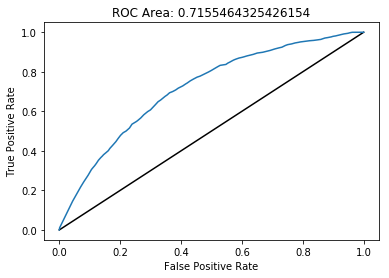

In [178]:
plot_roc_curve(log_reg_model.summary)

Evaluating the model on the test set.

In [179]:
test_with_prediction = log_reg_model.transform(test)
test_with_prediction.show(5)

+--------+----------------+----------------------+------+--------------------+--------------------+--------------------+----------+
|SLA_days|dept_name_std_cd|request_address_zip_cd|target|            features|       rawPrediction|         probability|prediction|
+--------+----------------+----------------------+------+--------------------+--------------------+--------------------+----------+
|    0.13|   (6,[2],[1.0])|        (75,[0],[1.0])|     0|(82,[0,3,7],[0.13...|[1.32816443813510...|[0.79053684923979...|       0.0|
|    0.13|   (6,[2],[1.0])|        (75,[0],[1.0])|     0|(82,[0,3,7],[0.13...|[1.32816443813510...|[0.79053684923979...|       0.0|
|    0.13|   (6,[2],[1.0])|        (75,[0],[1.0])|     0|(82,[0,3,7],[0.13...|[1.32816443813510...|[0.79053684923979...|       0.0|
|    0.13|   (6,[2],[1.0])|        (75,[0],[1.0])|     0|(82,[0,3,7],[0.13...|[1.32816443813510...|[0.79053684923979...|       0.0|
|    0.13|   (6,[2],[1.0])|        (75,[0],[1.0])|     0|(82,[0,3,7],[0.13..